# Approximate q-learning

In this notebook you will teach a __tensorflow__ neural network to do Q-learning.

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for tensorflow, but you will find it easy to adapt it to almost any python-based deep learning framework.

In [179]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [180]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

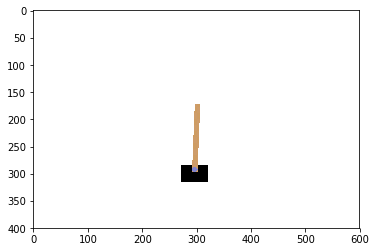

In [181]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Approximate (deep) Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://s14.postimg.org/uzay2q5rl/qlearning_scheme.png)

For your first run, please only use linear layers (L.Dense) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: agent's observations are not normalized so sigmoids may become saturated from init.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [182]:
import tensorflow as tf
import keras
import keras.layers as L
tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

In [183]:
def build_mlp(
        input_placeholder,
        output_size,
        n_layers=2,
        size=64,
        activation=tf.tanh,
        output_activation=None
        ):

    output = input_placeholder
    for i in range(n_layers):
        output = tf.layers.dense(output, size, activation=activation,
                use_bias=True, kernel_initializer=tf.orthogonal_initializer,
                name="dense_{}".format(i))
    output = tf.layers.dense(output, output_size, activation=output_activation,
            use_bias=True, kernel_initializer=tf.orthogonal_initializer,
            name="dense_{}".format(n_layers))

    return output

In [184]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    
    q_values = network.predict(state[None])[0]
    
    ###YOUR CODE
    action = None
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(q_values)

    return action

In [185]:
assert network.output_shape == (None, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert network.layers[-1].activation == keras.activations.linear, "please make sure you predict q-values without nonlinearity"

# test epsilon-greedy exploration
s = env.reset()
assert np.shape(get_action(s)) == (), "please return just one action (integer)"
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount(
        [get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed'%eps)

e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `tf.stop_gradient` function which basically says "consider this thing constant when doingbackprop".

In [186]:
# Create placeholders for the <s, a, r, s'> tuple and a special indicator for game end (is_done = True)
states_ph = tf.placeholder('float32', shape=(None,) + state_dim)
actions_ph = tf.placeholder('int32', shape=[None])
rewards_ph = tf.placeholder('float32', shape=[None])
next_states_ph = tf.placeholder('float32', shape=(None,) + state_dim)
is_done_ph = tf.placeholder('bool', shape=[None])

In [187]:
#get q-values for all actions in current states
predicted_qvalues = network(states_ph)

#select q-values for chosen actions
predicted_qvalues_for_actions = tf.reduce_sum(
    predicted_qvalues * tf.one_hot(actions_ph, n_actions), axis=1)

In [188]:
gamma = 0.99

# compute q-values for all actions in next states
predicted_next_qvalues = network(next_states_ph)

# compute V*(next_states) using predicted next q-values
next_state_values = tf.reduce_max(predicted_next_qvalues, axis=1)

# compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
target_qvalues_for_actions = rewards_ph + gamma * next_state_values

# at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
target_qvalues_for_actions = tf.where(is_done_ph, rewards_ph, target_qvalues_for_actions)

In [189]:
#mean squared error loss to minimize
loss = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2
loss = tf.reduce_mean(loss)

# training function that resembles agent.update(state, action, reward, next_state) from tabular agent
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [190]:
assert tf.gradients(loss, [predicted_qvalues_for_actions])[0] is not None, "make sure you update q-values for chosen actions and not just all actions"
assert tf.gradients(loss, [predicted_next_qvalues])[0] is None, "make sure you don't propagate gradient w.r.t. Q_(s',a')"
assert predicted_next_qvalues.shape.ndims == 2, "make sure you predicted q-values for all actions in next state"
assert next_state_values.shape.ndims == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
assert target_qvalues_for_actions.shape.ndims == 1, "there's something wrong with target q-values, they must be a vector"

### Playing the game

In [191]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        
        if train:
            sess.run(train_step,{
                states_ph: [s], actions_ph: [a], rewards_ph: [r], 
                next_states_ph: [next_s], is_done_ph: [done]
            })

        total_reward += r
        s = next_s
        if done: break
            
    return total_reward

In [192]:
epsilon = 0.5

In [193]:
for i in range(1000):
    session_rewards = [generate_session(epsilon=epsilon, train=True) for _ in range(100)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    if np.mean(session_rewards) > 300:
        print ("You Win!")
        break


epoch #0	mean reward = 18.230	epsilon = 0.500
epoch #1	mean reward = 17.650	epsilon = 0.495
epoch #2	mean reward = 18.800	epsilon = 0.490
epoch #3	mean reward = 17.600	epsilon = 0.485
epoch #4	mean reward = 18.940	epsilon = 0.480
epoch #5	mean reward = 17.120	epsilon = 0.475
epoch #6	mean reward = 17.740	epsilon = 0.471
epoch #7	mean reward = 17.530	epsilon = 0.466
epoch #8	mean reward = 20.410	epsilon = 0.461
epoch #9	mean reward = 19.790	epsilon = 0.457
epoch #10	mean reward = 17.290	epsilon = 0.452
epoch #11	mean reward = 17.060	epsilon = 0.448
epoch #12	mean reward = 16.160	epsilon = 0.443
epoch #13	mean reward = 16.380	epsilon = 0.439
epoch #14	mean reward = 15.110	epsilon = 0.434
epoch #15	mean reward = 15.430	epsilon = 0.430
epoch #16	mean reward = 15.340	epsilon = 0.426
epoch #17	mean reward = 16.550	epsilon = 0.421
epoch #18	mean reward = 19.370	epsilon = 0.417
epoch #19	mean reward = 16.810	epsilon = 0.413
epoch #20	mean reward = 16.710	epsilon = 0.409
epoch #21	mean reward =

epoch #173	mean reward = 15.620	epsilon = 0.088
epoch #174	mean reward = 11.020	epsilon = 0.087
epoch #175	mean reward = 12.050	epsilon = 0.086
epoch #176	mean reward = 12.730	epsilon = 0.085
epoch #177	mean reward = 13.130	epsilon = 0.084
epoch #178	mean reward = 12.210	epsilon = 0.084
epoch #179	mean reward = 12.540	epsilon = 0.083
epoch #180	mean reward = 11.970	epsilon = 0.082
epoch #181	mean reward = 11.100	epsilon = 0.081
epoch #182	mean reward = 13.880	epsilon = 0.080
epoch #183	mean reward = 12.410	epsilon = 0.079
epoch #184	mean reward = 11.640	epsilon = 0.079
epoch #185	mean reward = 15.240	epsilon = 0.078
epoch #186	mean reward = 15.180	epsilon = 0.077
epoch #187	mean reward = 15.240	epsilon = 0.076
epoch #188	mean reward = 12.170	epsilon = 0.076
epoch #189	mean reward = 13.040	epsilon = 0.075
epoch #190	mean reward = 12.790	epsilon = 0.074
epoch #191	mean reward = 11.980	epsilon = 0.073
epoch #192	mean reward = 12.410	epsilon = 0.073
epoch #193	mean reward = 12.740	epsilon 

epoch #344	mean reward = 14.700	epsilon = 0.016
epoch #345	mean reward = 14.120	epsilon = 0.016
epoch #346	mean reward = 14.080	epsilon = 0.015
epoch #347	mean reward = 14.790	epsilon = 0.015
epoch #348	mean reward = 13.280	epsilon = 0.015
epoch #349	mean reward = 14.350	epsilon = 0.015
epoch #350	mean reward = 13.890	epsilon = 0.015
epoch #351	mean reward = 17.510	epsilon = 0.015
epoch #352	mean reward = 13.900	epsilon = 0.015
epoch #353	mean reward = 14.160	epsilon = 0.014
epoch #354	mean reward = 15.530	epsilon = 0.014
epoch #355	mean reward = 16.080	epsilon = 0.014
epoch #356	mean reward = 19.540	epsilon = 0.014
epoch #357	mean reward = 16.330	epsilon = 0.014
epoch #358	mean reward = 16.620	epsilon = 0.014
epoch #359	mean reward = 14.390	epsilon = 0.014
epoch #360	mean reward = 13.980	epsilon = 0.013
epoch #361	mean reward = 14.210	epsilon = 0.013
epoch #362	mean reward = 16.480	epsilon = 0.013
epoch #363	mean reward = 14.800	epsilon = 0.013
epoch #364	mean reward = 19.530	epsilon 

epoch #515	mean reward = 56.260	epsilon = 0.003
epoch #516	mean reward = 45.160	epsilon = 0.003
epoch #517	mean reward = 32.430	epsilon = 0.003
epoch #518	mean reward = 28.380	epsilon = 0.003
epoch #519	mean reward = 20.460	epsilon = 0.003
epoch #520	mean reward = 21.100	epsilon = 0.003
epoch #521	mean reward = 15.640	epsilon = 0.003
epoch #522	mean reward = 15.490	epsilon = 0.003
epoch #523	mean reward = 17.540	epsilon = 0.003
epoch #524	mean reward = 31.160	epsilon = 0.003
epoch #525	mean reward = 36.590	epsilon = 0.003
epoch #526	mean reward = 39.400	epsilon = 0.003
epoch #527	mean reward = 30.080	epsilon = 0.003
epoch #528	mean reward = 30.870	epsilon = 0.002
epoch #529	mean reward = 34.580	epsilon = 0.002
epoch #530	mean reward = 28.010	epsilon = 0.002
epoch #531	mean reward = 25.740	epsilon = 0.002
epoch #532	mean reward = 30.620	epsilon = 0.002
epoch #533	mean reward = 21.210	epsilon = 0.002
epoch #534	mean reward = 20.470	epsilon = 0.002
epoch #535	mean reward = 21.900	epsilon 

epoch #687	mean reward = 13.260	epsilon = 0.001
epoch #688	mean reward = 13.970	epsilon = 0.000
epoch #689	mean reward = 14.770	epsilon = 0.000
epoch #690	mean reward = 17.740	epsilon = 0.000
epoch #691	mean reward = 17.980	epsilon = 0.000
epoch #692	mean reward = 14.750	epsilon = 0.000
epoch #693	mean reward = 14.400	epsilon = 0.000
epoch #694	mean reward = 19.940	epsilon = 0.000
epoch #695	mean reward = 31.980	epsilon = 0.000
epoch #696	mean reward = 28.410	epsilon = 0.000
epoch #697	mean reward = 24.270	epsilon = 0.000
epoch #698	mean reward = 28.470	epsilon = 0.000
epoch #699	mean reward = 15.400	epsilon = 0.000
epoch #700	mean reward = 11.740	epsilon = 0.000
epoch #701	mean reward = 13.950	epsilon = 0.000
epoch #702	mean reward = 18.550	epsilon = 0.000
epoch #703	mean reward = 16.970	epsilon = 0.000
epoch #704	mean reward = 19.950	epsilon = 0.000
epoch #705	mean reward = 22.120	epsilon = 0.000
epoch #706	mean reward = 23.670	epsilon = 0.000
epoch #707	mean reward = 23.490	epsilon 

AssertionError: Make sure epsilon is always nonzero during training

### How to interpret results


Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

### Record videos

As usual, we now use `gym.wrappers.Monitor` to record a video of our agent playing the game. Unlike our previous attempts with state binarization, this time we expect our agent to act ~~(or fail)~~ more smoothly since there's no more binarization error at play.

As you already did with tabular q-learning, we set epsilon=0 for final evaluation to prevent agent from exploring himself to death.

In [ ]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session(epsilon=0, train=False) for _ in range(100)]
env.close()


In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices